In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import gc
import warnings
import zipfile
from datetime import date, datetime, timedelta
from pathlib import Path

os.environ["USE_PYGEOS"] = "0"

import duckdb
import geopandas as gpd
import leafmap
import matplotlib.pyplot as plt
import movingpandas as mpd
import numpy as np
import pandas as pd
import seaborn as sns
from keplergl import KeplerGl
from pptx import Presentation
from pptx.dml.color import RGBColor
from pptx.util import Cm, Pt
from tqdm import tqdm

warnings.filterwarnings("ignore")

# 加古川市_公用車走行データ（走行履歴）
- Data: [G空間情報センター 加古川市_公用車走行データ](https://www.geospatial.jp/ckan/dataset/kakogawacity-car-data)

> ◆「加古川市公用車走行データ（走行履歴）」データ仕様   
> 対象期間：2016年1月～2017年12月 車両台数：計172台（当初）   
> 属性情報：車両ID/時刻/緯度/経度 データ：1ファイルで1ID毎1年分としています。   
> その他：10分間まった同じ場所にいた場合や、エンジン停止などでデータ未取得の時間が10分以上となった場合を滞在と定義し、滞在と滞在を結ぶプローブ（時系列データ）において、起終点から一定の距離を離れる点までを匿名加工処理として削除しています。

# CSVファイルの読み込み+統合
- Data：[加古川市_公用車走行データ（走行履歴）_2017](https://www.geospatial.jp/ckan/dataset/kakogawacity-car-data/resource/6686c2da-b47c-4cfc-86e1-b4026b41079c)
- 同一車両で timestamp の重複があるので、データの重複除去が必要
- 座標参照系が EPSG:4301（Tokyo） なので EPSG:4326（WGS84）に変換

- 車両別のCSVファイルのままだと扱いづらいので、先に一つのファイルに統合する
    - 普段の業務で扱うデータはデータ量が大きいので、先に必要な日付や道路区間のデータを抽出してから処理
- 統合したデータは GeoParquet と CSVファイルで出力

In [2]:
# zipファイルを解凍せずに内部のCSVファイルにアクセス
zip_path = r".\data\raw\kakogawacity\2017.zip"

dfs = []

with zipfile.ZipFile(zip_path) as zf:
    csv_path_list = [f for f in zf.namelist() if f.endswith(".csv")]

    for csv_path in csv_path_list:
        with zf.open(csv_path) as f:
            df = pd.read_csv(
                f,
                encoding="utf-8",
                names=["vehicle_id", "timestamp", "latitude", "longitude"],
                dtype={"vehicle_id": str},
                parse_dates=[1],
            )
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
del dfs
gc.collect()

# 同一車両でtimestampの重複があるので、最初のレコード以外は除去
df = df.sort_values(["vehicle_id", "timestamp"], ignore_index=True)

print("Before drop duplicates", len(df))
df = df.drop_duplicates(["vehicle_id", "timestamp"], keep="first", ignore_index=True)
print("After drop duplicates", len(df))

# GeoDataFrameに変換してTOKYO Datum -> WGS84に変換
df = gpd.GeoDataFrame(
    df, crs=4301, geometry=gpd.points_from_xy(df["longitude"], df["latitude"])
)

df = df.to_crs(4326)
df = df.drop(columns=["latitude", "longitude"])
df.head(2)

Before drop duplicates 27094285
After drop duplicates 27007892


,vehicle_id,timestamp,geometry
0,20150400001,2016-12-27 08:55:13,POINT (134.82190 34.82527)
1,20150400001,2016-12-27 08:55:14,POINT (134.82196 34.82536)


- エクスポート
    - (データ量が多いので、GitHub の dataフォルダには1日分のデータを抽出した後のファイルを保存）

In [ ]:
%%time
# CSV
df.to_csv(
    r".\data\kakogawacity_probe_2017.csv",
    encoding="utf-8",
    index=False
)

In [3]:
%%time
# GeoParquet
df.to_parquet(
    r".\data\kakogawacity_probe_2017.parquet",
    index=False,
    compression="zstd"
)

CPU times: total: 32.4 s
Wall time: 45.2 s


# データ抽出
- 走行ルートの可視化・アニメーション作成は、サンプルとして1日分のデータを使用する

1. SQLによる抽出・・・[DuckDB](https://duckdb.org/) を使用（高速）
    - CSVファイルから抽出する（Parquet の読み込みはできるが GeoParquet はうまく読み込めなかった）
    - CSVを読み込む場合、車両IDは数値と文字列が混在しているため all_varchar=1 のオプションが必要

In [4]:
%%time
con = duckdb.connect(r":memory:")

sql = """
SELECT
    vehicle_id
    ,strptime(timestamp, '%Y-%m-%d %H:%M:%S') AS timestamp
    ,geometry
FROM
    read_csv_auto('data\kakogawacity_probe_2017.csv', all_varchar=1)
WHERE
    substring(timestamp, 1, 10) = '2017-02-13'
;
"""
df = duckdb.query(sql).to_df()
df = gpd.GeoDataFrame(df, crs=4326, geometry=gpd.GeoSeries.from_wkt(df["geometry"]))

print(len(df))
df.head(2)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

98460
CPU times: total: 8.56 s
Wall time: 10.9 s


,vehicle_id,timestamp,geometry
0,20150400001,2017-02-13 09:54:44,POINT (134.81899 34.81670)
1,20150400001,2017-02-13 09:54:45,POINT (134.81896 34.81663)


2. GeoPandasによるデータ抽出
    - GeoParquet を読み込んで抽出

In [5]:
%%time
target_date = date(2017, 2, 13)

df = gpd.read_parquet(r".\data\kakogawacity_probe_2017.parquet")
df = df[df["timestamp"].dt.date == target_date]

print(len(df))
df.head(2)

98460
CPU times: total: 34.8 s
Wall time: 46.5 s


,vehicle_id,timestamp,geometry
28139,20150400001,2017-02-13 09:54:44,POINT (134.81899 34.81670)
28140,20150400001,2017-02-13 09:54:45,POINT (134.81896 34.81663)


# トリップの分割処理
- 移動体データ分析ライブラリ [MovingPandas](https://github.com/movingpandas/movingpandas) で処理
- データ未取得の時間が10分以上 / 10分間同じ場所にいた場合は滞在となる->滞在地点でトリップを分割

In [6]:
# 車両IDをIDとしてトリップを作成
trajc = mpd.TrajectoryCollection(df, traj_id_col="vehicle_id", t="timestamp")
trajc

TrajectoryCollection with 35 trajectories

In [7]:
# データ未取得の時間が10分以上でトリップ分割
trajc = mpd.ObservationGapSplitter(trajc).split(gap=timedelta(minutes=10))
trajc

TrajectoryCollection with 100 trajectories

In [ ]:
# 同じ場所に10分間以上滞在したらトリップ分割
# TODO：起終点付近の走行履歴が削除されているため条件見直しが必要
# trajc = mpd.StopSplitter(trajc).split(
#     max_diameter=30, min_duration=timedelta(minutes=10)
# )
# trajc

- トリップ分割後の走行軌跡データ：GeoPackage にエクスポート
    - GeoPackageはQGIS用のデータファイルとして準備（主題図作成用のデータもまとめて格納するため）

In [8]:
gpkg_path = r".\data\kakogawacity_probe.gpkg"

In [9]:
df = trajc.to_traj_gdf()
df["traj_id"] = df["vehicle_id"]
df["vehicle_id"] = df["vehicle_id"].str.split("_", expand=True, n=1)[0]

df.to_file(gpkg_path, layer=f"trajc_20170213")

- leafmapで可視化して確認してみる
    - 位置情報の異常で、離れた地点を移動したことになっているトリップが存在すると判明。

In [10]:
m = leafmap.Map()
m.add_gdf(trajc.to_traj_gdf(), layer_name="trajc", center=(35.2042, 134.8739))
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

<img src=".\image\trajc.png" style="margin-top: 20px;">

# 異常データのクレンジング
- 走行履歴の2点間速度を計算して、「1000km/h」を超える速度があるトリップはトリップ単位で除外する。
    - 加古川公用車の走行履歴は1秒ごとのデータ。特に問題のない走行履歴であっても、timestampがずれている等の理由で2点間速度が200km/h以上といった値が出ることがある。
    - 今回は離れた地点を移動したことになっているトリップだけ除去したいので、1000km/h を閾値とした。

In [11]:
# 2点間速度を計算
trajc.add_speed(overwrite=True, name="speed", units=("km", "h"))

In [12]:
# 2点間速度の分布を確認
max_speeds = [traj.get_max("speed") for traj in trajc]

In [13]:
max(max_speeds)

28022.38969692934

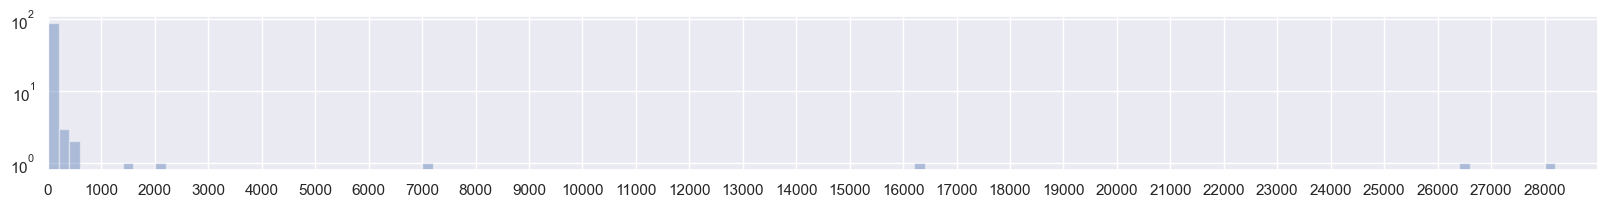

In [14]:
sns.set()
plt.figure(figsize=(20, 2))
g = sns.distplot(max_speeds, bins=range(0, 30000, 200), kde=False)
g.set(yscale="log", xlim=(0, 29000), xticks=range(0, 29000, 1000));

In [15]:
# 2点間速度の最大値が 1000km/h以下のトリップだけを抽出する
max_speed = 1000
cleaned = mpd.TrajectoryCollection(
    [traj for traj in trajc if traj.get_max("speed") <= max_speed]
)
cleaned

TrajectoryCollection with 94 trajectories

- leafmapでクレンジング後の走行軌跡データを確認
    - 位置情報に異常のあるトリップが除去できた。

In [16]:
m = leafmap.Map()
m.add_gdf(cleaned.to_traj_gdf(), layer_name="trajc_cleaned", center=(35.2042, 134.8739))
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

<img src=".\image\trajc_cleaned.png" style="margin-top: 20px;">

# エクスポート

- トリップの走行軌跡データ：GeoPackageにエクスポート

In [17]:
df = cleaned.to_traj_gdf()

# TrajectoryIDから車両IDを取り出す
df["traj_id"] = df["vehicle_id"]
df["vehicle_id"] = df["vehicle_id"].str.split("_", expand=True, n=1)[0]

gpkg_path = r".\data\kakogawacity_probe.gpkg"
df.to_file(gpkg_path, layer="trajc_cleaned_20170213")

- 走行履歴データ： GeoParquet にエクスポート

In [18]:
df = cleaned.to_point_gdf().reset_index()

df["traj_id"] = df["vehicle_id"]
df["vehicle_id"] = df["vehicle_id"].str.split("_", expand=True, n=1)[0]

df.to_parquet(
    r".\data\kakogawacity_probe_cleaned_20170213.parquet",
    index=False,
    compression="zstd",
)

# アニメーション作成
- [Kepler.gl for Jupyter](https://github.com/keplergl/kepler.gl/blob/master/bindings/kepler.gl-jupyter)
- <font color="darkorange">CAUTION：環境によってはバグが発生してしまう。</font>https://github.com/keplergl/kepler.gl/issues/1993
- 今回はエラーが発生しない仮想環境に切り替えて実行

In [2]:
df = gpd.read_parquet(r".\data\kakogawacity_probe_cleaned_20170213.parquet")

# 緯度・経度・高度・UNIX時間が必要
df["longitude"] = df["geometry"].x
df["latitude"] = df["geometry"].y
df["altitude"] = 0
df["unix_time"] = df["timestamp"].astype(np.int64) // 10**9

df.head(2)

,timestamp,vehicle_id,geometry,speed,traj_id,longitude,latitude,altitude,unix_time
0,2017-02-13 09:54:44,20150400001,POINT (134.81899 34.81670),31.241816,20150400001_0,134.818985,34.816704,0,1486979684
1,2017-02-13 09:54:45,20150400001,POINT (134.81896 34.81663),31.241816,20150400001_0,134.818958,34.816629,0,1486979685


- GeoJSONに変換

In [3]:
geo_json = dict(type="FeatureCollection", features=[])

for (vehicle_id, traj_id), group in df.groupby(["vehicle_id", "traj_id"]):
    feature = dict(
        type="Feature",
        geometry=None,
        properties=dict(vehicle_id=vehicle_id, traj_id=traj_id),
    )
    feature["geometry"] = dict(
        type="LineString",
        coordinates=group[["longitude", "latitude", "altitude", "unix_time"]]
        .to_records(index=False)
        .tolist(),
    )
    geo_json["features"].append(feature)

with open("probe_animation_20170213.geojson", mode="w") as f:
    f.write(str(geo_json))

- Map Config

In [4]:
center = df["latitude"].mean(), df["longitude"].mean()

config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "probe-demo",
                    "type": "trip",
                    "config": {
                        "dataId": "trip_data",
                        "label": "trip_data",
                        "color": [218, 0, 0],
                        "highlightColor": [252, 242, 26, 255],
                        "columns": {"geojson": "_geojson"},
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "thickness": 2,
                            "colorRange": {
                                "name": "ColorBrewer Set1-6",
                                "type": "qualitative",
                                "category": "ColorBrewer",
                                "colors": [
                                    "#e41a1c",
                                    "#377eb8",
                                    "#4daf4a",
                                    "#984ea3",
                                    "#ff7f00",
                                    "#ffff33",
                                ],
                            },
                            "trailLength": 250,
                            "sizeRange": [0, 10],
                        },
                        "hidden": False,
                        "textLabel": [
                            {
                                "field": None,
                                "color": [255, 255, 255],
                                "size": 18,
                                "offset": [0, 0],
                                "anchor": "start",
                                "alignment": "center",
                            }
                        ],
                    },
                    "visualChannels": {
                        "colorField": {"name": "vehicle_id", "type": "string"},
                        "colorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear",
                    },
                }
            ],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "trip_data": [{"name": "vehicle_id", "format": None}]
                    },
                    "compareMode": False,
                    "compareType": "absolute",
                    "enabled": True,
                },
                "brush": {"size": 0.5, "enabled": False},
                "geocoder": {"enabled": False},
                "coordinate": {"enabled": False},
            },
            "layerBlending": "normal",
            "splitMaps": [],
            "animationConfig": {"currentTime": 1616174376576.6997, "speed": 0.5},
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": center[0],
            "longitude": center[1],
            "pitch": 0,
            "zoom": 11,
            "isSplit": False,
        },
        "mapStyle": {
            "styleType": "dark",
            "topLayerGroups": {},
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False,
            },
            "threeDBuildingColor": [
                9.665468314072013,
                17.18305478057247,
                31.1442867897876,
            ],
            "mapStyles": {},
        },
    },
}

- Display Map

In [5]:
m = KeplerGl(data={"trip_data": geo_json}, config=config, height=600)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'probe-demo', 'type…

<img src=".\image\animation.png" style="margin-top: 20px;">

- Save Map

In [6]:
m.save_to_html(file_name="probe_animation_20170213.html", read_only=True)

Map saved to probe_animation_20170213.html!


## PowerPoint資料作成の例（QGIS + python-pptx）
- QGIS で作成した個車の走行ルートの画像をPowerPoint に一括出力することを想定。
- 事前準備をしてから次のセルを実行
1. QGIS で車両別の走行軌跡を可視化して、印刷レイアウトを作成する。
2. QGIS の Pythonコンソールからエディタを表示して「export_qgis_layout.py」を実行してレイアウトを一括出力<br> [GIS実習オープン教材：QGISでのPython入門](https://gis-oer.github.io/gitbook/book/materials/python/01/01.html)
3. テンプレートの PowerPoint を準備

In [7]:
prs = Presentation(r".\pptx\template.pptx")

base_path = Path(r".\pptx\image")

for png_path in tqdm(base_path.glob(r"**\*.png")):
    # 新しいスライドを追加
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)

    # 車両ID（画像のファイル名）をテキストボックスに出力
    txBox = slide.shapes.add_textbox(
        left=Cm(0.5), top=Cm(2.1), width=Cm(10), height=Cm(1)
    )
    tf = txBox.text_frame
    tf.text = f"車両ID：{png_path.stem}"
    tf.paragraphs[0].font.size = Pt(18)

    # 地図の画像を挿入
    slide.shapes.add_picture(str(png_path), left=Cm(0.71), top=Cm(3.07))

prs.save("probe_pptx_20170213.pptx")

35it [00:00, 163.55it/s]
